# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [1]:
# Imports

import calendar
from code_id_translator import *
from datetime import datetime
import ipywidgets as widgets
from ipywidgets import interact, fixed
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from neiss_backend_v8 import *
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import metrics
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import sys
import xlrd



In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

## Read the pickled neissYYYY.xlsx file

xlsx_to_pckl.ipynb is used to create the pickled file

In [3]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    dfNeiss = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception('ERROR:  {} does not exist'.format(pckl_fname))


Reading /Users/mcorbett/Boston University/MET_CS677_DataScienceWithPython/Project/data/NEISS/neiss_data.pckl  ... done!


In [4]:
dfNeiss.shape

(7352927, 19)

In [5]:
dfNeiss.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,100001,1999-12-24,41,2,1.0,0,31,71,NaN,1,0,0,3299,0,41 YR FEMALE FELL WHILE WALKING. DX: SEVERE MU...,/RIGHT BUTTOCKS & BACK.,S,71,68.1086
1,100002,1999-12-27,80,1,2.0,0,31,57,NaN,1,0,0,611,0,80 YR MALE FELL IN BATHROOM/HE HIT RIGHT RIBS ...,DX: FRACTURED RIGHT RIBS-UPPER TRUNK,S,71,68.1086
2,100003,1999-12-27,4,1,1.0,0,75,53,NaN,1,0,0,1328,0,4 YR MALE HAD METAL LARGE WAGON WHEEL FALL & H...,DX: CONTUSIN ON HEAD/NO LOC.,S,71,68.1086
3,100005,1999-12-28,18,1,0.0,NaN,94,53,NaN,1,0,0,1205,0,CONTUSION EAR - STRUCK IN RIGHT EAR WITH BASKE...,NaN,S,7,68.1086
4,100009,1999-12-28,19,2,0.0,NaN,92,64,NaN,1,0,0,5031,0,SPRAIN THUMB - INJURED THUMB WHEN SNOWBOARDING,NaN,S,7,68.1086


### Update Neiss with column code dictionary from Excel file

In [6]:
column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [7]:
neiss = Neiss(dfNeiss)

In [8]:
dfNeiss.shape

(7352927, 19)

### Time based graphs

#### Injuries Per Year

 Note:  The first graph requires the entire dataset

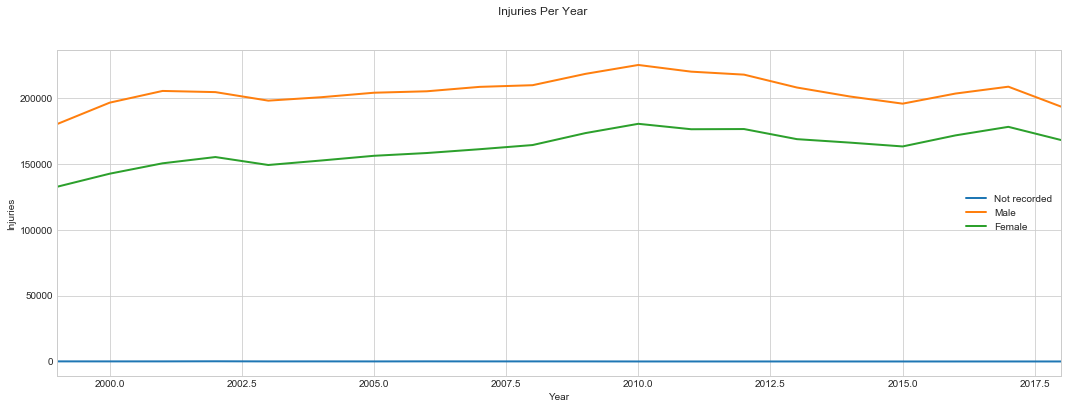

In [9]:
#df = neiss.getDataFrame()
date_name, stat_name = 'Treatment_Date', 'Sex'

showInjuriesPerYear(dfNeiss, date_name, stat_name, 'Injuries Per Year')

#### Injuries Per 52 Weeks of the Year

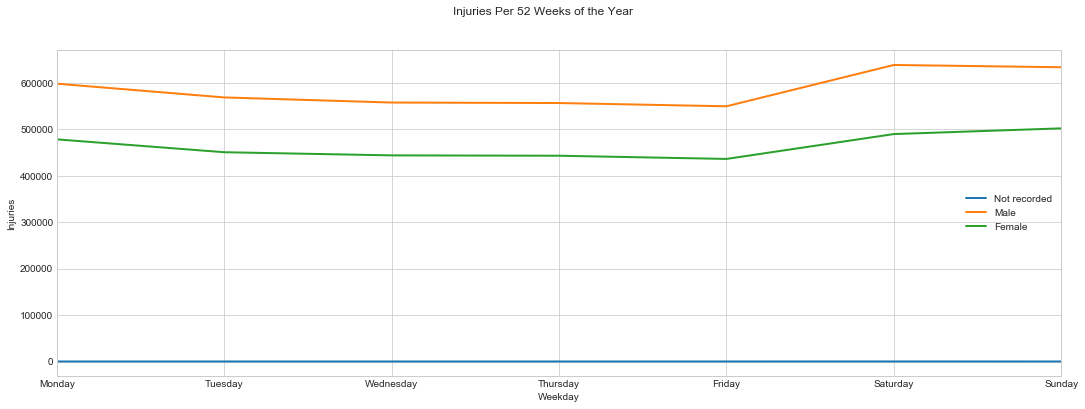

In [10]:
showInjuriesPerMonthOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per 52 Weeks of the Year')

#### Injuries Per Month of the Year

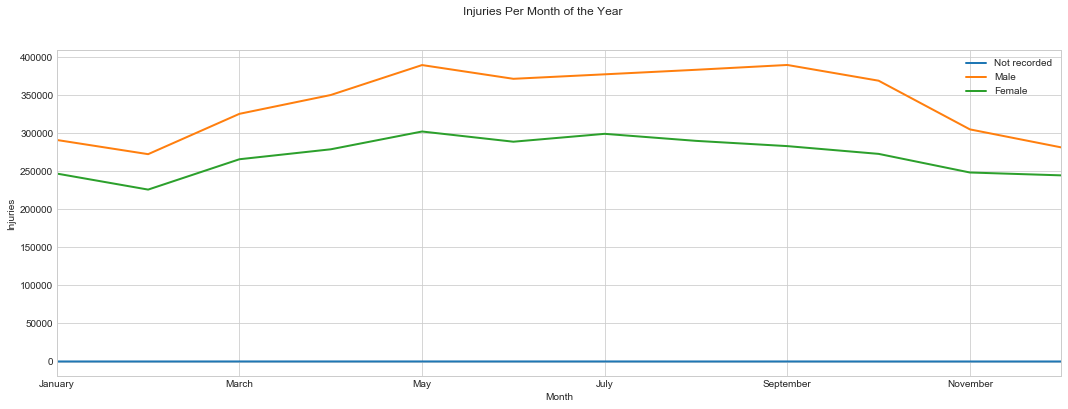

In [24]:
showInjuriesPerMonthOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Month of the Year')

#### Injuries Per Week of the Year

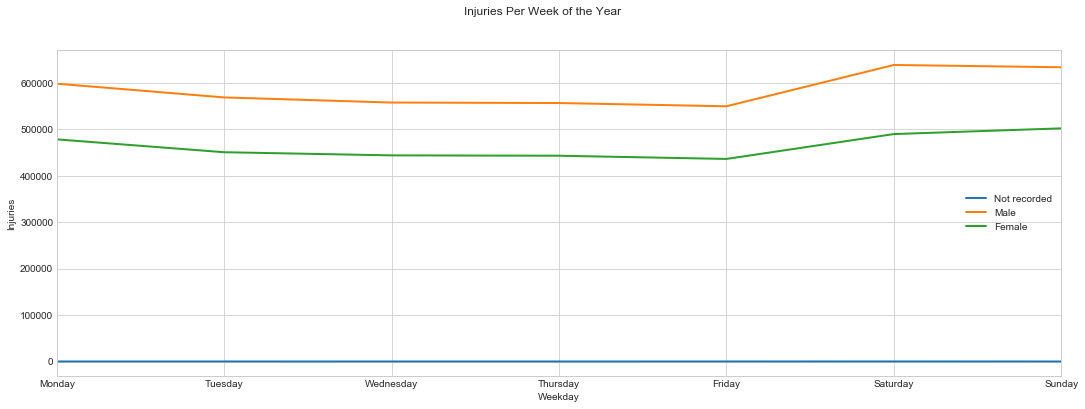

In [12]:
showInjuriesPerWeekOfTheYear(dfNeiss, date_name, stat_name, 'Injuries Per Week of the Year')

### PearsonChiSquared

dfCategorical.head:
        Sex  Race  Body_Part  Diagnosis  Disposition  Location  \
11180     1     1         92         53            1         0   
250299    2     1         79         57            4         1   
87281     2     0         31         53            1         0   
362790    2     1         79         64            1         1   
328824    2     1         92         59            1         1   

        Fire_Involvement  Product_1  Product_2  PSU Stratum  
11180                  0       1205          0   90       C  
250299                 0       1137          0   24       M  
87281                  0       1807        611   48       S  
362790                 0       1842          0   55       L  
328824                 0        464          0   95       V  
code


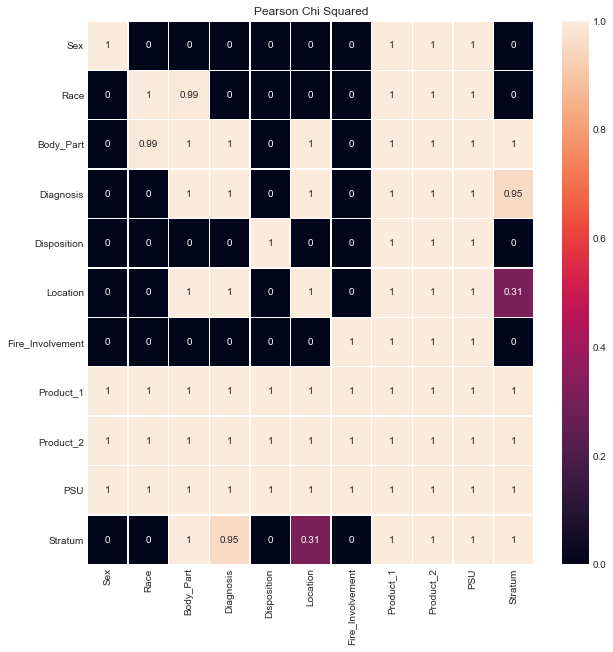

In [13]:
# build the correlation matrix (contingency table)
dfCategorical = dfNeiss.copy()
categorical = ['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 'Location',
               'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum' ]
dfCategorical = dfCategorical.xs(categorical, axis=1)
dfCategorical.dropna(inplace=True)
dfCategorical['Race'] = [int(x) for x in dfCategorical['Race']]
dfCategorical = dfCategorical.sample(3000)
print('dfCategorical.head:\n{}'.format(dfCategorical.head()))

codeIdTranslator = CodeIdTranslatorDataFrame(dfCategorical, categorical)
print(codeIdTranslator.state)
codeIdTranslator.transformColumns()

pcs1 = PearsonChiSquared(dfCategorical)
dfCategoricalCorrMatrix = pcs1.getCorrMatrixDataframe(categorical)


fig, ax = plt.subplots(figsize=(10, 10))

#sns.heatmap(dfCorrMatrix, annot=True, mask=mask, fmt="d", linewidths=0.4, ax=ax)
g = sns.heatmap(dfCategoricalCorrMatrix, annot=True, linewidths=0.4, ax=ax)
g.set_title('Pearson Chi Squared')
# Fix the top and bottom margins of the heatmap
bottom_y, top_y = plt.ylim() 
bottom_y += 0.5 
top_y -= 0.5 
plt.ylim(bottom_y, top_y)

plt.show() 

### Python Corr

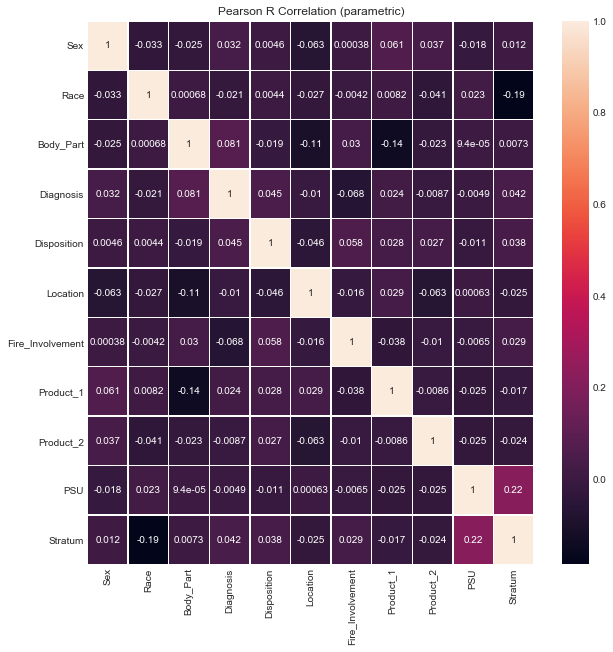

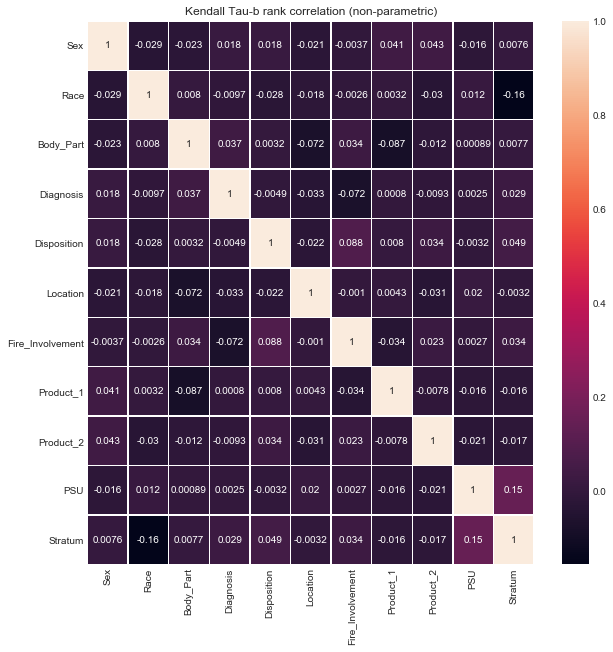

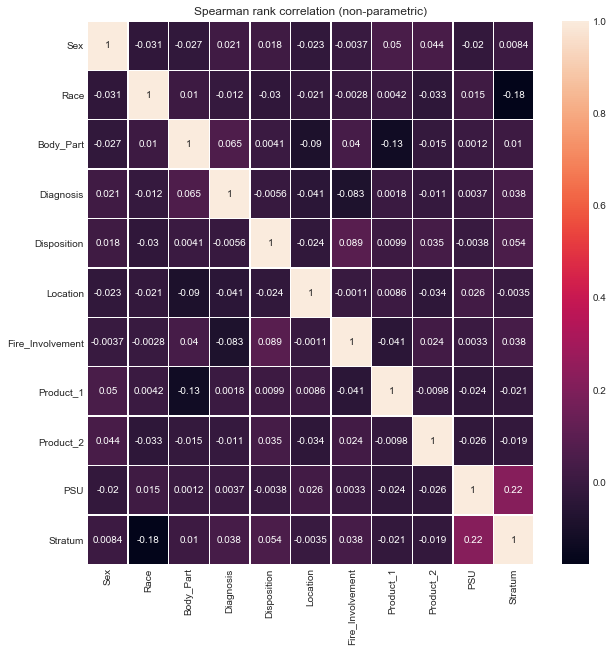

In [14]:

methods = {
    'pearson' : 'Pearson R Correlation (parametric)',  # not good for categorical data
        # For pearson:
        # both variables should be normally distributed
        # There should be no significant outliers
        # Each variable should be continuous
        # The two variables have a linear relationship
        # The observations are paired observations.
        # Should support homoscedascity.  Homoscedascity simply refers to ‘equal variances’.
    'kendall' : 'Kendall Tau-b rank correlation (non-parametric)',
        # The variables are measured on an ordinal or continuous scale.
        # Desirable if your data appears to follow a monotonic relationship.
    'spearman' : 'Spearman rank correlation (non-parametric)'
        # Does not assume that both datasets are normally distributed
    }


for key in methods.keys():
    dfCategoricalPythonCorr = dfCategorical.corr(method = key)

    fig, ax = plt.subplots(figsize=(10, 10))

    g = sns.heatmap(dfCategoricalPythonCorr, annot=True, linewidths=0.4, ax=ax)
    g.set_title(methods[key])

    # Fix the top and bottom margins of the heatmap
    bottom_y, top_y = plt.ylim() 
    bottom_y += 0.5 
    top_y -= 0.5 
    plt.ylim(bottom_y, top_y)

    plt.show() 


In [15]:
#sns.pairplot(df)

In [16]:
def getHighCorrelations(df, dfCategoricalCorrMatrix, minValue):
    high_correlations = []
    for yIndex, y in enumerate(dfCategoricalCorrMatrix.index):
        for xIndex, x in enumerate(dfCategoricalCorrMatrix.columns):
            #if xIndex >= yIndex:
            #    break

            if (x != y) and (dfCategoricalCorrMatrix[y][x] > minValue):
                Y = y
                X = x
                if len(df[X].unique()) > len(df[Y].unique()):
                    # Keep the smallest item on the X axis
                    Y, X = X, Y
                    
                if (Y, X) not in high_correlations:
                    high_correlations.insert(-1, (Y, X))
    high_correlations.sort()
    return high_correlations

high_correlations = getHighCorrelations(dfCategorical, dfCategoricalCorrMatrix, 0.95)
for n in high_correlations:
    print(n)

('Body_Part', 'Location')
('Body_Part', 'Race')
('Body_Part', 'Stratum')
('Diagnosis', 'Body_Part')
('Diagnosis', 'Location')
('Diagnosis', 'Stratum')
('PSU', 'Body_Part')
('PSU', 'Diagnosis')
('PSU', 'Disposition')
('PSU', 'Fire_Involvement')
('PSU', 'Location')
('PSU', 'Race')
('PSU', 'Sex')
('PSU', 'Stratum')
('Product_1', 'Body_Part')
('Product_1', 'Diagnosis')
('Product_1', 'Disposition')
('Product_1', 'Fire_Involvement')
('Product_1', 'Location')
('Product_1', 'PSU')
('Product_1', 'Product_2')
('Product_1', 'Race')
('Product_1', 'Sex')
('Product_1', 'Stratum')
('Product_2', 'Body_Part')
('Product_2', 'Diagnosis')
('Product_2', 'Disposition')
('Product_2', 'Fire_Involvement')
('Product_2', 'Location')
('Product_2', 'PSU')
('Product_2', 'Race')
('Product_2', 'Sex')
('Product_2', 'Stratum')


In [17]:
def chooseHighValueTargets(df, xSel, ySel, threshold):
    dfSel = df.xs([xSel, ySel], axis=1)
    s = dfSel.groupby(ySel).sum()
    s = s.sort_values(by=[xSel], ascending=False)
    cum = s[xSel].cumsum()
    maxAllowed = s[xSel].sum() * threshold
    print(maxAllowed)
    indices = cum[cum.values < maxAllowed].index

    print(len(dfSel))
    #[dfSel.drop(x)  if x not in indices for x in dfSel.index]
    #print(len(dfSel))
    return dfSel
    #return 0

#df1 = chooseHighValueTargets(df, xSel='Body_Part', ySel='Diagnosis', threshold=0.80)
#print(df1)


In [18]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

#print(high_correlations.values)
select = high_correlations[0]
#print(select)
lCorrelations = ['{}, {}'.format(y, x) for y, x in high_correlations]
correlationDropDownSel = widgets.Dropdown(
    options=lCorrelations,
    value=lCorrelations[0],
    description='correlations',
    disabled=False,
)

typeDropDownSel = widgets.Dropdown(
    options=['swarm', 'scatter'],
    value='swarm',
    description='plot_type',
    disabled=False,
)

wHBox = widgets.HBox([correlationDropDownSel, typeDropDownSel])
wVBox = widgets.VBox([wHBox, button, output])

display(wVBox)

def on_button_clicked(b):
    with output:
        sel = correlationDropDownSel.value
        (xSel, ySel) = [x.strip() for x in sel.split(',')]
        print('-{}-, -{}-'.format(xSel, ySel))
        
        #df1 = chooseHighValueTargets(df, xSel, ySel, threshold=0.80)

        
        correlations(codeIdTranslator, xSel, ySel, typeDropDownSel.value)

        #sns.pairplot(dfSel, hue=xSel)
button.on_click(on_button_clicked)


## SKLearn

Gaussian Naive Bayes (GaussianNB)


Can perform online updates to model parameters via partial_fit method. 

For details on algorithm used to update feature means and variance online, 

see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:


http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf


In [25]:
    currentState = codeIdTranslator.getState()
    codeIdTranslator.setState('id')
    dfCorrelationsId = codeIdTranslator.getDataFrame().copy()
    codeIdTranslator.setState('code')
    dfCorrelationsCode = codeIdTranslator.getDataFrame().copy()
    codeIdTranslator.setState(currentState)


In [26]:
df1 = dfCorrelationsCode.copy()

le = {}

for col in df1.columns:
    le[col] = preprocessing.LabelEncoder()
    le[col].fit(df1[col].unique())
    print('{0:12s} => {1}'.format(col, le[col].classes_))
    df1[col] = le[col].transform(df1[col])
    
df1

Sex          => [1 2]
Race         => [0 1 2 3 4 5 6]
Body_Part    => [ 0 30 31 32 33 34 35 36 37 38 75 76 77 79 80 81 82 83 84 85 87 88 89 92
 93 94]
Diagnosis    => [41 42 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70 71 72 73 74]
Disposition  => [1 2 4 5 6 8]
Location     => [0 1 2 4 5 8 9]
Fire_Involvement => [0 1 2 3 4]
Product_1    => [ 115  131  140  214  215  247  263  276  277  281  322  342  370  371
  374  379  380  413  417  419  420  431  432  438  443  450  460  461
  463  464  466  469  471  474  478  480  482  519  546  550  557  559
  566  572  601  604  606  611  612  613  617  618  620  627  628  638
  639  648  649  652  654  661  663  667  670  676  679  685  687  689
  692  694  698  701  707  809  814  827  828  830  832  834  836  837
  841  845  847  852  855  857  862  870  871  881  882  884  885  886
  887  893  895  896  899  909  910  921  934  940  942  949  954  956
  960  963  966  979  982  983 1062 1107 1112 1114 1122 1123 1127

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
11180,0,1,23,7,0,0,0,137,0,87,0
250299,1,1,13,11,2,1,0,130,0,22,2
87281,1,0,2,7,0,0,0,244,24,46,3
362790,1,1,13,18,0,1,0,252,0,53,1
328824,1,1,23,13,0,1,0,29,0,92,4
...,...,...,...,...,...,...,...,...,...,...,...
351967,0,2,2,7,0,1,0,316,0,55,4
244334,0,3,10,16,0,1,0,343,101,38,4
132445,0,0,5,10,0,1,0,259,0,15,4
98008,0,0,23,11,0,6,0,292,0,15,4


In [27]:
gnb = GaussianNB()

outputFeature = 'Diagnosis'

inputFeatures = categorical.copy()
inputFeatures.remove('Diagnosis')

# Train classifier
gnb.fit(
    df1[inputFeatures].values,
    df1[outputFeature]
)

print(df1['Body_Part'].values)
print(df1[outputFeature].values)

[23 13  2 ...  5 23 11]
[ 7 11  7 ... 10 11  7]


In [28]:
y_pred = gnb.predict(dfCorrelationsId[inputFeatures])
print(y_pred)

# Print results
print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
      .format(
          df1.shape[0],
          (df1[outputFeature] != y_pred).sum(),
          100*(1-(df1[outputFeature] != y_pred).sum()/df1.shape[0])
))


[ 5  5  5 ...  5 11 11]
Number of mislabeled points out of a total 3000 points : 2800, performance 06.67%


In [29]:
pd.DataFrame(
    {'predicted': le[outputFeature].inverse_transform(y_pred),
     'actual':    df1[outputFeature]})

,predicted,actual
11180,51,7
250299,51,11
87281,51,7
362790,51,18
328824,51,13
...,...,...
351967,51,7
244334,57,16
132445,51,10
98008,57,11


In [30]:
 metrics.confusion_matrix(y_pred, df1[outputFeature])

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [ 18,   5,  11,   7,   7,  30,  20, 314,   6,  25,  47, 283,  10,
        499,  12,   4, 146,  25, 297,   5,   4,   1,  34,   5,   1, 201,
    